# Optimize and Evaluate Image Generation Models

- **Goal:** Show a standard workflow for optimizing and evaluating a image generation model.
- **Model:** [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)
- **Dataset:** [data-is-better-together/open-image-preferences-v1](https://huggingface.co/datasets/data-is-better-together/open-image-preferences-v1)
- **Libraries:** [diffusers](https://github.com/huggingface/diffusers)
- **Optimization Algorithms:** quantiser(hqq_diffusers), compiler(torch_compile)
- **Evaluation Metrics:**
    - **Base Metrics:** elapsed_time
    - **Stateful Metrics:** lpi, ssim, psnr, clip_score, cmmd

## Getting Started


### Install the dependencies

To install the dependencies, run the following command:

In [ ]:
!pip install pruna

### Set the device

Normally, we would set the device to the best available device to make the most out of the optimization process.

In [1]:
import torch

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

## Load the model

Before we can optimize the model, we need to ensure that we can load the model and tokenizer correctly and that they can fit in memory. For this example, we will use a nice and small image generation model, [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4), but feel free to use any [text-to-image model on Hugging Face](https://huggingface.co/models?pipeline_tag=text-to-image).

In [2]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=torch.bfloat16)
pipe = pipe.to(device)

Multiple distributions found for package optimum. Picked distribution: optimum
W0516 10:30:28.334000 13970 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
/Users/davidberenstein/Documents/programming/pruna/prunatree/pruna/.venv/lib/python3.12/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Now we've loaded the pipeline components, let's take a look at some of the output it is able to produce. 

  0%|          | 0/50 [00:00<?, ?it/s]

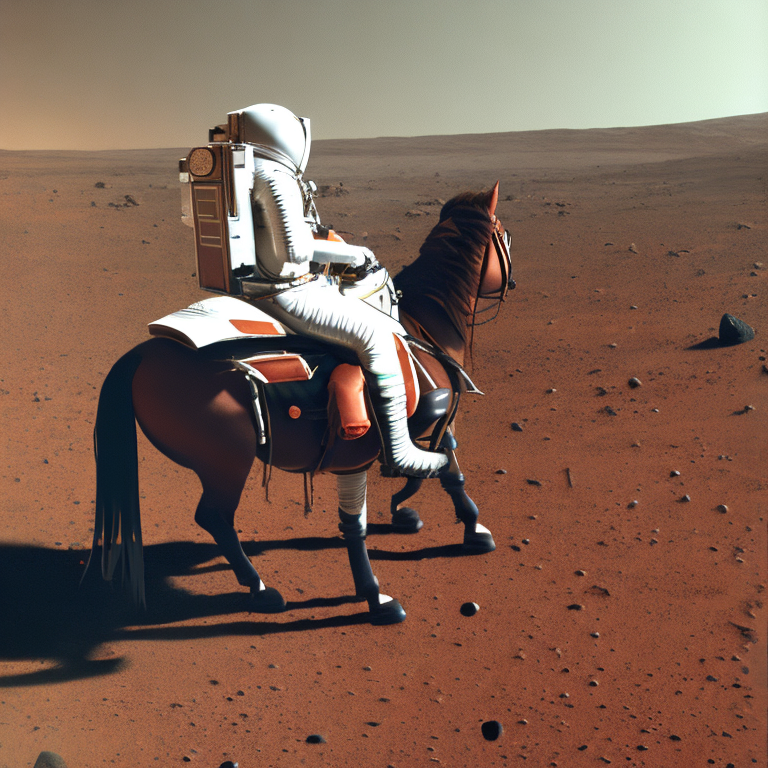

In [79]:
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt)
image.images[0]

As we can see, the model is able to generate a nicely matching image based on the provided input prompt.

## Define the SmashConfig

Now we know the model is working, let's continue with the optimization process and define the `SmashConfig`, which we will use later on to optimize the model.

Not all optimization algorithms are available for all models but we can learn a bit more about different optimization algorithms and their requirements in the [Algorithms Overview](https://docs.pruna.ai/en/stable/compression.html) section of the documentation.

For the current optimization, we will be using the [`hqq-diffusers` quantizer](https://docs.pruna.ai/en/stable/compression.html#hqq-diffusers) and a  [``deepcache`` cacher](https://docs.pruna.ai/en/stable/compression.html#deepcache). We will updating some parameters for these algorithms, setting `hqq_diffusers_weight_bits` to `4`. This is one of the many configurations and will just serve as an example.

Let's define the `SmashConfig` object.

In [18]:
from pruna import SmashConfig

smash_config = SmashConfig(device=device)
smash_config["quantizer"] = "hqq_diffusers"
smash_config["hqq_diffusers_weight_bits"] = 8
smash_config["hqq_diffusers_group_size"] = 128
smash_config["hqq_diffusers_backend"] = "marlin"
smash_config["cacher"] = "deepcache"

## Smash the model

Now that we have defined the `SmashConfig` object, we can smash the model. We will be using the `smash` function to smash the model and pass the `model` and `smash_config` to it. We also make a deep copy of the model to avoid modifying the original model.

In [19]:
import copy

from pruna import smash

copy_pipe = copy.deepcopy(pipe)
smashed_pipe = smash(
    model=copy_pipe,
    smash_config=smash_config,
)

INFO - Starting quantizer hqq_diffusers...
100%|██████████| 216/216 [00:15<00:00, 14.19it/s]
INFO - quantizer hqq_diffusers was applied successfully.
INFO - Starting cacher deepcache...
INFO - cacher deepcache was applied successfully.


Now we've optimized the model. Let's see if everything still works as expected and we can run some inference with the optimized model.

In [ ]:
prompt = "a photo of an astronaut riding a horse on mars"
image = smashed_pipe(prompt)
image.images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

As we can see, the model is able to generate a similar image as the original model. 

If you notice a significant difference, it might have several reasons, the model, the configuration, the hardware, etc. As optimization can be non-deterministic, we encourage you to retry the optimization process or try out different configurations and models to find the best fit for your use case but also feel free to reach out to us on [Discord](https://discord.gg/Tun8YgzxZ9) if you have any questions or feedback.

## Evaluate the smashed model

Now that we have optimized the model, we can evaluate the performance of the optimized model. We will be using the `EvaluationAgent` to evaluate the performance of the optimized model. We will do so with some basic metrics, such as `elapsed_time`, as well as some stateful metrics, such as `lpi`, `ssim`, `psnr`, `clip_score`, and `cmmd`. An overview of the different metrics can be found in our [documentation](https://docs.pruna.ai/).

Let's define the `EvaluationAgent` object and start the evaluation process. Note that we are using the `datamodule.limit_datasets(10)` method to limit the number of datasets to 10, which is just for the sake of time.